## DenseNet121 Transfer Learning Pipeline for CIFAR-10

In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10
from keras.layers import Dense,Dropout, Flatten, Conv2D, MaxPooling2D, Layer, Lambda, BatchNormalization, GlobalAveragePooling2D

import numpy as np

#**Preprocess Data**

In [2]:
def preprocess_data(X, Y):
    """
    Pre-processes the data for the model

        :param X: numpy.ndarray of shape (m, 32, 32, 3)
            containing the CIFAR 10 data, where m is the
            number of data points

        :param Y: numpy.ndarray of shape (m,) containing
            the CIFAR 10 labels for X

        :returns: X_p, Y_p
    """
    X_p = K.applications.densenet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

**Loas CIFAR-10**

In [3]:
# load cifar 10
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Visilations**

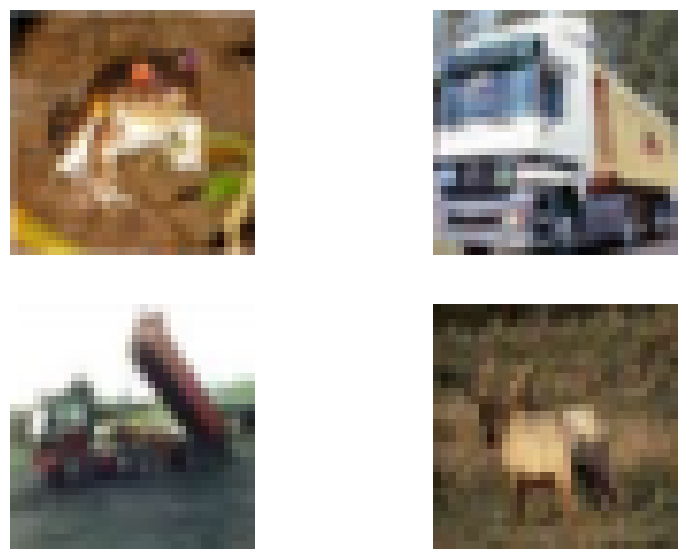

In [4]:
# Visilations
plt.figure(figsize = (10,7))
plt.subplot(221)

# equivalent but more general
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(x_train[0])
ax1.axis('off')

# add a subplot with no frame
ax2 = plt.subplot(222, frameon=False)
ax2.imshow(x_train[1])
ax2.axis('off')

# add a polar subplot
ax3 = plt.subplot(223)
ax3.imshow(x_train[2])
ax3.axis('off')

# add a red subplot that shares the x-axis with ax1
ax4 = plt.subplot(224)
ax4.imshow(x_train[3])
ax4.axis('off')
plt.show()


**Pre-procces**

In [5]:
# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

#**Detailed Architecture**

**Defining the Input Tensor**

In [6]:
inputs = K.Input(shape=(32, 32, 3))


**Upscaling the Input**

DenseNet121 expects inputs of a larger size (here, 160×160) since it was originally trained on ImageNet images that are usually larger. Upscaling ensures compatibility with the pre-trained network.

In [7]:
'''
tf.image.resize_with_pad resizes the image to the target size while maintaining the aspect ratio and adding padding if needed.
The bilinear interpolation method is used for smooth resizing.
'''
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(
    x, 160, 160, method=tf.image.ResizeMethod.BILINEAR))(inputs)


**Loading the Base DenseNet121 Model**

In [8]:
base_model = K.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3))


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Adding Custom Output Layers**

In [9]:
out = base_model.output
out = Flatten()(out)
out = BatchNormalization()(out)
out = Dense(124, activation='relu')(out)
out = Dropout(0.7)(out)
out = BatchNormalization()(out)
out = Dense(64, activation='relu')(out)
out = Dropout(0.4)(out)
out = Dense(10, activation='softmax')(out)


**Model compile**

In [11]:

model = K.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=K.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

#**DenseNet121 Training**

**Set callbacks functions**

In [12]:
checkpointer = K.callbacks.ModelCheckpoint(filepath='DenseNet121_transferlearning.h5',
                                              monitor='val_accuracy',
                                              save_best_only=True)

earlystopper = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5)
lr_reducer = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                         patience=2, verbose=1)



**Training**

In [14]:
history = model.fit(x=x_train,
          y=y_train,
          batch_size=128,
          epochs=20,
          callbacks=[checkpointer,earlystopper,lr_reducer],
          validation_data=(x_test, y_test))

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.5651 - loss: 1.3357

391/391 ━━━━━━━━━━━━━━━━━━━━ 321s 404ms/step - accuracy: 0.5654 - loss: 1.3347 - val_accuracy: 0.7865 - val_loss: 0.7345 - learning_rate: 0.0010
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8477 - loss: 0.5231

391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.8477 - loss: 0.5230 - val_accuracy: 0.8250 - val_loss: 0.5794 - learning_rate: 0.0010
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8920 - loss: 0.3761

391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.8920 - loss: 0.3761 - val_accuracy: 0.8327 - val_loss: 0.5660 - learning_rate: 0.0010
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9078 - loss: 0.3211

391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.9078 - loss: 0.3211 - val_accuracy: 0.8759 - val_loss: 0.4029 - learning_rate: 0.0010
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9226 - loss: 0.2706

391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.9226 - loss: 0.2706 - val_accuracy: 0.8845 - val_loss: 0.4073 - learning_rate: 0.0010
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9220 - loss: 0.2613

391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.9220 - loss: 0.2613 - val_accuracy: 0.8938 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9384 - loss: 0.2140

391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.9384 - loss: 0.2140 - val_accuracy: 0.9015 - val_loss: 0.3511 - learning_rate: 0.0010
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9446 - loss: 0.1968
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9446 - loss: 0.1968 - val_accuracy: 0.8964 - val_loss: 0.3729 - learning_rate: 0.0010
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9674 - loss: 0.1224

391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.9674 - loss: 0.1223 - val_accuracy: 0.9533 - val_loss: 0.1591 - learning_rate: 1.0000e-04
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9835 - loss: 0.0653

391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.9835 - loss: 0.0652 - val_accuracy: 0.9551 - val_loss: 0.1619 - learning_rate: 1.0000e-04
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9897 - loss: 0.0455


Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.9897 - loss: 0.0455 - val_accuracy: 0.9559 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 12/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9928 - loss: 0.0342

391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.9928 - loss: 0.0342 - val_accuracy: 0.9569 - val_loss: 0.1679 - learning_rate: 1.0000e-05
Epoch 13/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9927 - loss: 0.0339
Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9927 - loss: 0.0339 - val_accuracy: 0.9568 - val_loss: 0.1669 - learning_rate: 1.0000e-05
Epoch 14/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9922 - loss: 0.0344

391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.9922 - loss: 0.0344 - val_accuracy: 0.9570 - val_loss: 0.1672 - learning_rate: 1.0000e-06
Epoch 15/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9934 - loss: 0.0310
Epoch 15: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9934 - loss: 0.0310 - val_accuracy: 0.9568 - val_loss: 0.1668 - learning_rate: 1.0000e-06
Epoch 16/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9922 - loss: 0.0340 - val_accuracy: 0.9567 - val_loss: 0.1678 - learning_rate: 1.0000e-07
Epoch 17/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9939 - loss: 0.0296
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9939 - loss: 0.0296 - val_accuracy: 0.9567 - val_loss: 0.1675 - learning_rate: 1.0000e-07
Epoch 18/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - accuracy: 0.

#**Evaluation**

In [15]:
model.evaluate(x_test, y_test, batch_size=128, verbose=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9565 - loss: 0.1642


[0.1668463796377182, 0.9567000269889832]

**Plot Accurcy & Loss**

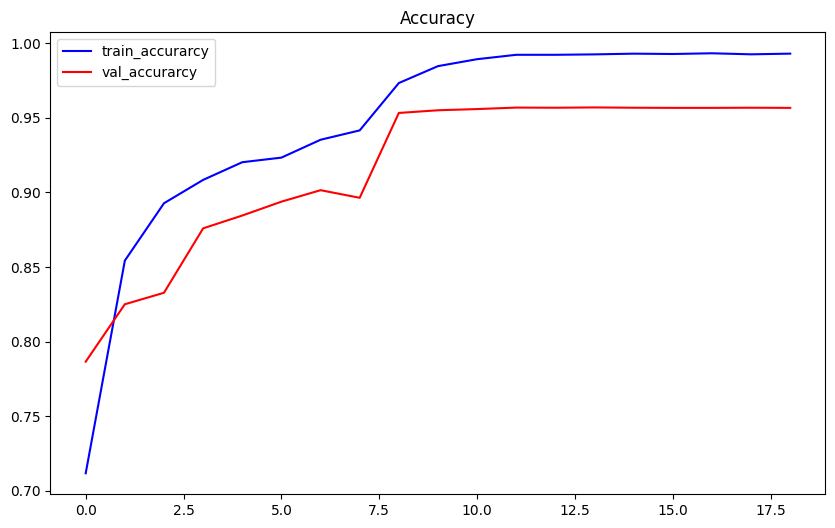

In [16]:
plt.figure(figsize = (10,6))
plt.plot(history.history['accuracy'], color = 'blue', label = 'train_accurarcy')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'val_accurarcy')
plt.legend()
plt.title('Accuracy')
plt.show()



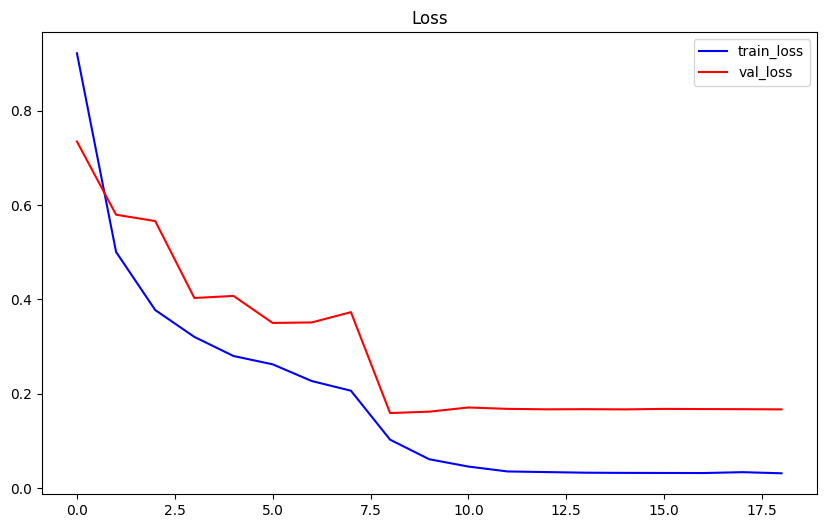

In [17]:
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], color = 'blue', label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'val_loss')
plt.legend()
plt.title('Loss')
plt.show()

**Predect on test**

In [18]:
Y_pred_test = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_test_classes = np.argmax(Y_pred_test,axis = 1)
# Convert validation observations to one hot vectors
Y_true_test = np.argmax(y_test,axis = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step


**Predect on train**

In [19]:
Y_pred_train = model.predict(x_train)
# Convert predictions classes to one hot vectors
Y_pred_classes_train = np.argmax(Y_pred_train,axis = 1)
# Convert validation observations to one hot vectors
Y_true_train = np.argmax(y_train,axis = 1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step


**Confusion Matrex**

Test:

Text(70.72222222222221, 0.5, 'True classes')

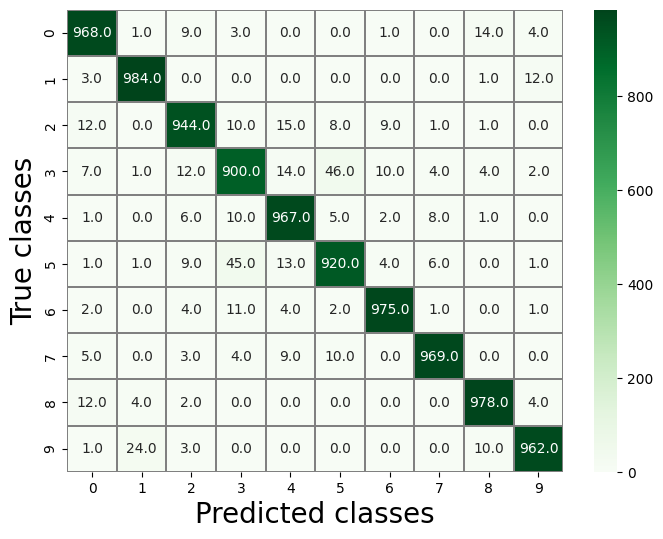

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

con_mat = confusion_matrix(Y_true_test, Y_pred_test_classes)

plt.figure(figsize = (8,6))
sns.heatmap(con_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray',
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

Train:

Text(70.72222222222221, 0.5, 'True classes')

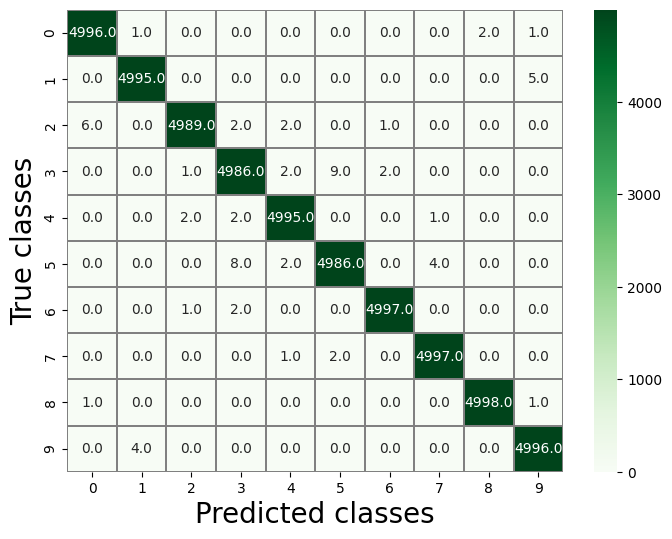

In [21]:
con_mat = confusion_matrix(Y_true_train, Y_pred_classes_train)

plt.figure(figsize = (8,6))
sns.heatmap(con_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray',
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

#**Classification Reports**

In [23]:
from sklearn.metrics import classification_report

**For Training**

In [24]:
print(classification_report(Y_true_test, Y_pred_test_classes))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1000
           1       0.97      0.98      0.98      1000
           2       0.95      0.94      0.95      1000
           3       0.92      0.90      0.91      1000
           4       0.95      0.97      0.96      1000
           5       0.93      0.92      0.92      1000
           6       0.97      0.97      0.97      1000
           7       0.98      0.97      0.97      1000
           8       0.97      0.98      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



**For Testing**

In [25]:
from sklearn.metrics import classification_report
print(classification_report(Y_true_train, Y_pred_classes_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000
           2       1.00      1.00      1.00      5000
           3       1.00      1.00      1.00      5000
           4       1.00      1.00      1.00      5000
           5       1.00      1.00      1.00      5000
           6       1.00      1.00      1.00      5000
           7       1.00      1.00      1.00      5000
           8       1.00      1.00      1.00      5000
           9       1.00      1.00      1.00      5000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

